In [1]:
import sys
# import pyccl as ccl
import pickle
import camb
from skylens import *
from survey_utils import *
import seaborn as sns
colors=sns.color_palette()
markers=['o','s','^','>','v']

In [2]:
ncpu=10
LC,scheduler_info=start_client(Scheduler_file=None,local_directory=None,ncpu=None,n_workers=ncpu,threads_per_worker=1,
                              memory_limit='120gb',dashboard_address=8811,processes=True)
client=client_get(scheduler_info=scheduler_info)

Start_client: No scheduler file, will start local cluster at  ./temp_skylens/pid11288/


/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8811 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44711 instead
  warnings.warn(


In [3]:
fig_home='./figures/'

In [4]:
s1_s2s={}
s1_s2s[corr_gg]=(0,0)
s1_s2s[corr_ll]=[(2,2),(2,-2)]
s1_s2s[corr_ggl]=(0,2)

In [5]:
corr_labels={corr:{} for corr in s1_s2s.keys()}
corr_labels[corr_ll][(2,2)]=r'$\xi_+$'
corr_labels[corr_ll][(2,-2)]=r'$\xi_-$'
corr_labels[corr_gg][(0,0)]=r'$gg$'
corr_labels[corr_ggl][(0,2)]=r'$g\gamma$'

corr_fnames={corr:{} for corr in s1_s2s.keys()}
corr_fnames[corr_ll][(2,2)]='llp'
corr_fnames[corr_ll][(2,-2)]='llm'
corr_fnames[corr_gg][(0,0)]='gg'
corr_fnames[corr_ggl][(0,2)]='ggl'

In [6]:
nside=512
window_lmax=nside
use_window=False
f_sky=0.3

do_pseudo_cl=False
do_xi=True

bin_cl=True
bin_xi=True

use_binned_l=False
use_binned_theta=False

store_win=True

nz_PS=10

do_cov=False
SSV_cov=False
tidal_SSV_cov=False
Tri_cov=False

In [7]:
z0=1 #1087
# zs_bin1=source_tomo_bins(zp=[z0],p_zp=np.array([1]),ns=30,use_window=use_window,nside=nside)
shear_zbins=lsst_source_tomo_bins(nbins=1,use_window=use_window,nside=nside,f_sky=f_sky)
galaxy_zbins=shear_zbins

ns0:  27.0
[0.10002    0.10082016 0.10162032 ... 2.99819964 2.9989998  2.99979996] 100 5
source_tomo_bins, zmax 5.0 2.999799959991998 0.5999699939987997
Tracer utils has no tracers


In [8]:
corrs=[corr_ggl]#corr_ll,corr_gg,corr_ggl]

In [9]:
bi=(0,0)
corr=corrs[0]
s=s1_s2s[corr]
if corr==corr_ll:
    s=(2,2)

In [10]:
#setup parameters
lmax_cl=5000 #2000
lmin_cl=0
l0=np.arange(lmin_cl,lmax_cl)

lmin_cl_Bins=lmin_cl+1
lmax_cl_Bins=lmax_cl-1
Nl_bins=50
l_bins=get_l_bins(l_min=lmin_cl_Bins,l_max=lmax_cl_Bins,N_bins=Nl_bins,binning_scheme='log',min_modes=50)#,binning_mode='decreasing')
# l_bins=np.unique(np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins+1)))
lb=.5*(l_bins[1:]+l_bins[:-1])
l_bins_center=lb*1
Nl_bins=len(lb)

# l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell
l=l0

In [11]:
theta_min=0.01/60
# theta_min=hp.nside2resol(512, arcmin = True)/60 #100/nside #1./60
theta_max=1200./60
n_theta_bins=151
# theta_bins,th=get_theta_bins(theta_min=theta_min,theta_max=theta_max,N_bins=n_theta_bins,binning_scheme='log',n_theta_samples=40)#,max_modes=1)
theta_bins=np.logspace(np.log10(theta_min),np.log10(theta_max),n_theta_bins+1)
th=np.logspace(np.log10(theta_min),np.log10(theta_max),n_theta_bins*40)
theta_bins_center=0.5*(theta_bins[1:]+theta_bins[:-1])
thb=theta_bins_center*1
n_theta_bins=len(thb)

#Hankel Transform setup
WT_kwargs={'l':l0,'l_cut_weights':np.ones_like(l0),'theta':th*d2r,'s1_s2':[(0,0),s],
           'wig_d_taper_order_low':16,'wig_d_taper_order_high':20}
# if globals().get('WT') is None:
WT=wigner_transform(**WT_kwargs )
# WT_b=wigner_transform(**WT_kwargs)
WT_b=WT
WT.gather_data()

Wigner ell max of  4999  too low for theta_min. Recommendation based on first few zeros of bessel  (0, 0)  : [ 826718.12952697 1897663.06981174 2974932.51878613 4053630.94403208
 5132871.41372096]


/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/wigner_transform.py:120: RuntimeWarning: divide by zero encountered in true_divide
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/wigner_transform.py:120: RuntimeWarning: invalid value encountered in true_divide
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/wigner_transform.py:120: RuntimeWarning: invalid value encountered in cos
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/wigner_functions.py:46: RuntimeWarning: divide by zero encountered in true_divide


Wigner ell max of  4999  too low for theta_min. Recommendation based on first few zeros of bessel  (0, 2)  : [1765496.89841239 2893635.38625681 3994607.14665893 5086473.54604677
 6174131.14727748]
l_cut_coupling: (6040, 6040) (6040,) (6040, 6040)
l_cut_coupling: (6040, 6040) (6040,) (6040, 6040)
Scattering WT data 1


In [12]:
wl=np.ones_like(l0)
taper_kwargs={'large_l_lower':lmax_cl*.8,'large_l_upper':lmax_cl,'low_l_lower':10,'low_l_upper':50}
WT.taper_f=None
tf=WT.taper(l0,**taper_kwargs)
th,wth=WT.projected_correlation(l_cl=l0,cl=wl*tf['taper_f'],taper=False,s1_s2=s,**taper_kwargs)
th,wth2=WT.projected_correlation(l_cl=l0,cl=wl,taper=False,s1_s2=s,**taper_kwargs)
th=WT.theta_deg[s]

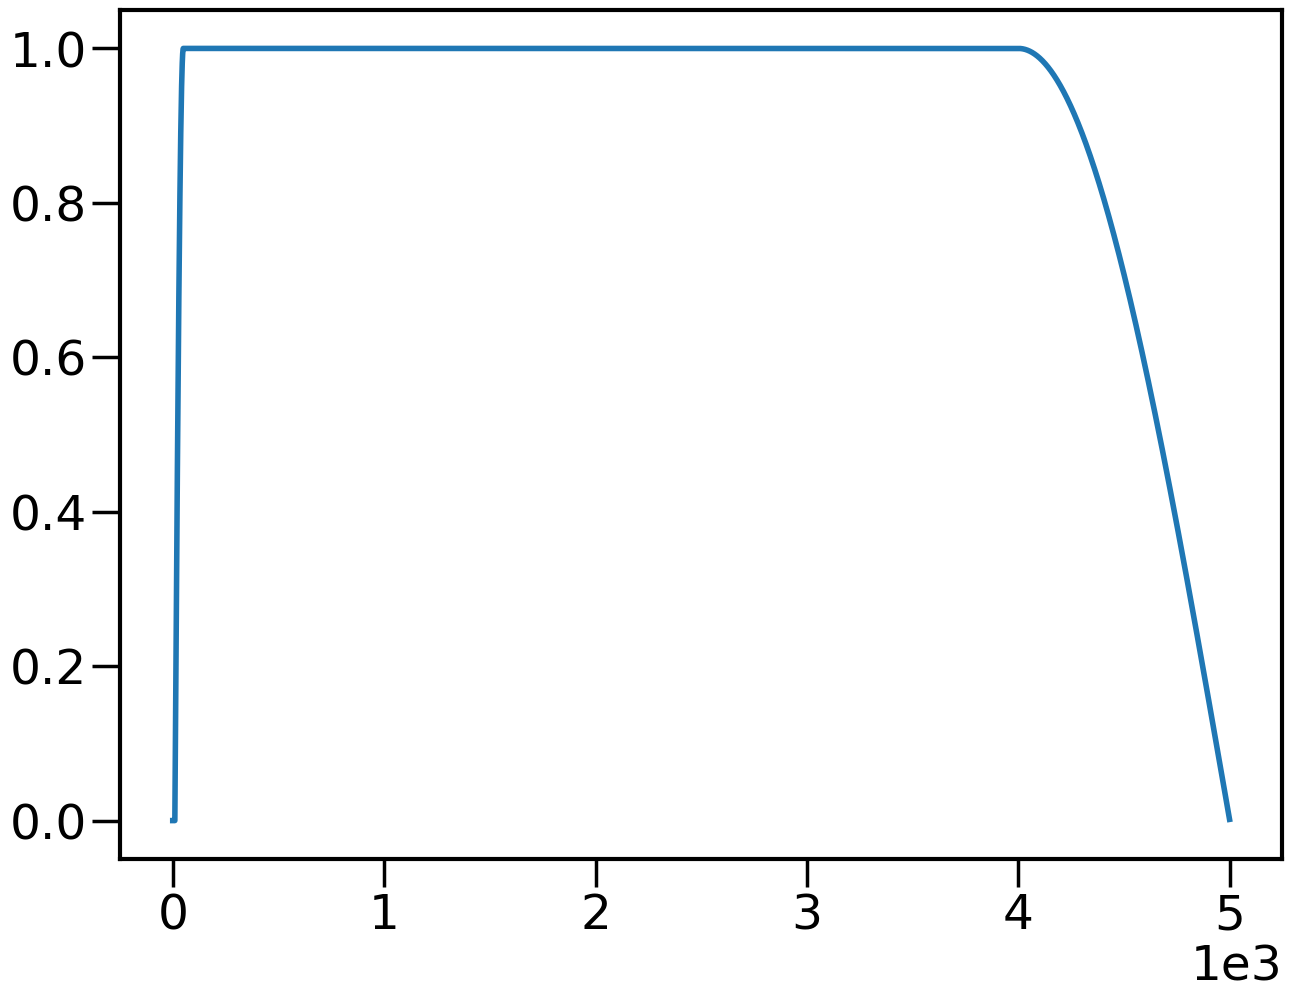

In [13]:
plot(l0,tf['taper_f'])
# xscale('log')

In [14]:
wth

array([19.76588302, 19.83803425, 19.91044885, ..., -1.27326636,
       -1.26833886, -1.26120154])

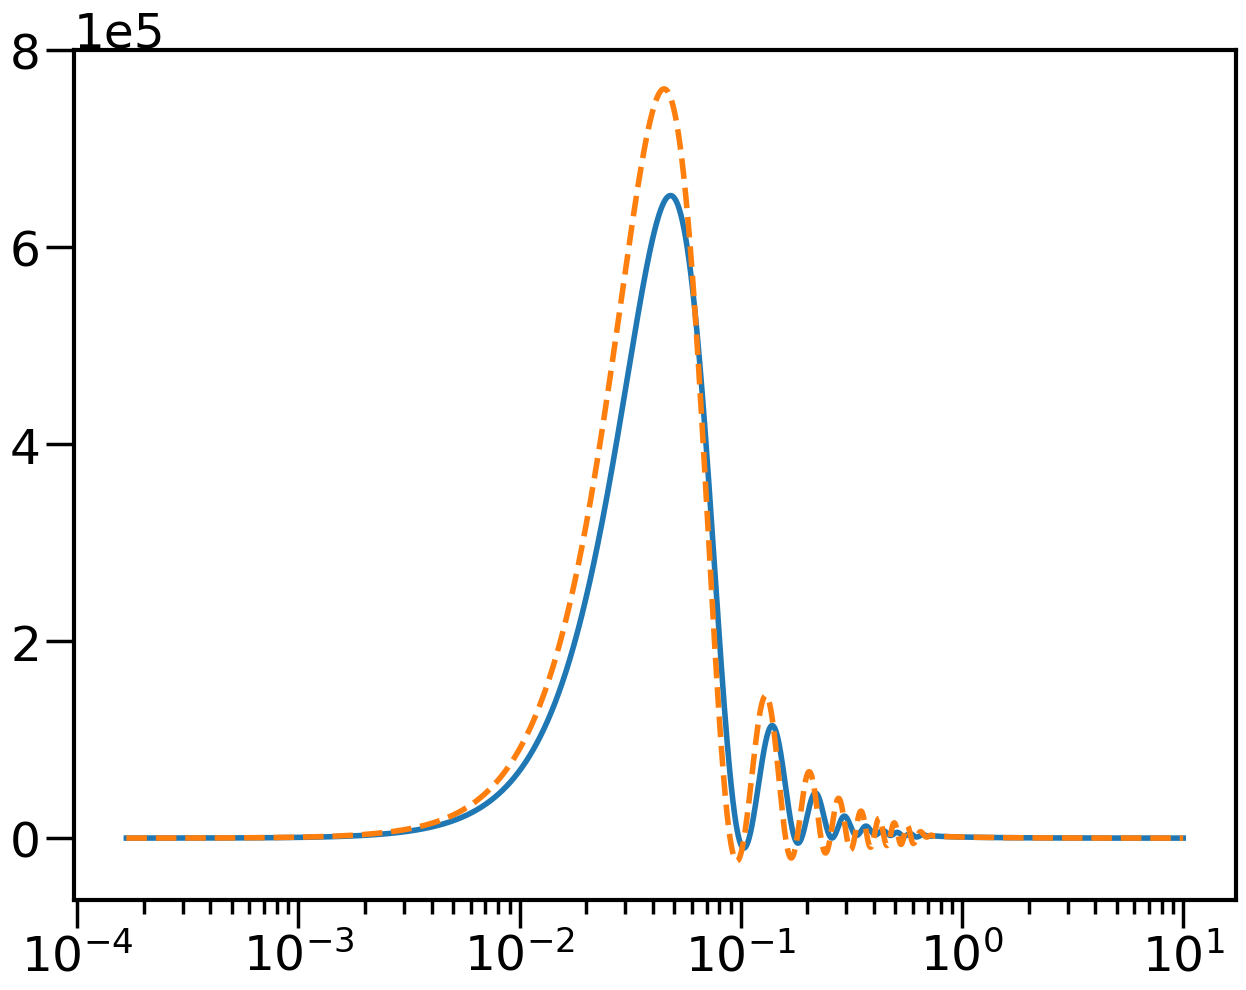

In [15]:
f=1#WT.theta_deg[s]**2
plot(WT.theta_deg[s],f*wth)
plot(WT.theta_deg[s],f*wth2,'--')

xscale('log')

In [16]:
theta_d=np.abs(th[:,None]-th)
wtheta_intp=interp1d(th,wth,bounds_error=False,kind='nearest')
wtheta_d=wtheta_intp(theta_d)

(0.0, 1.0)

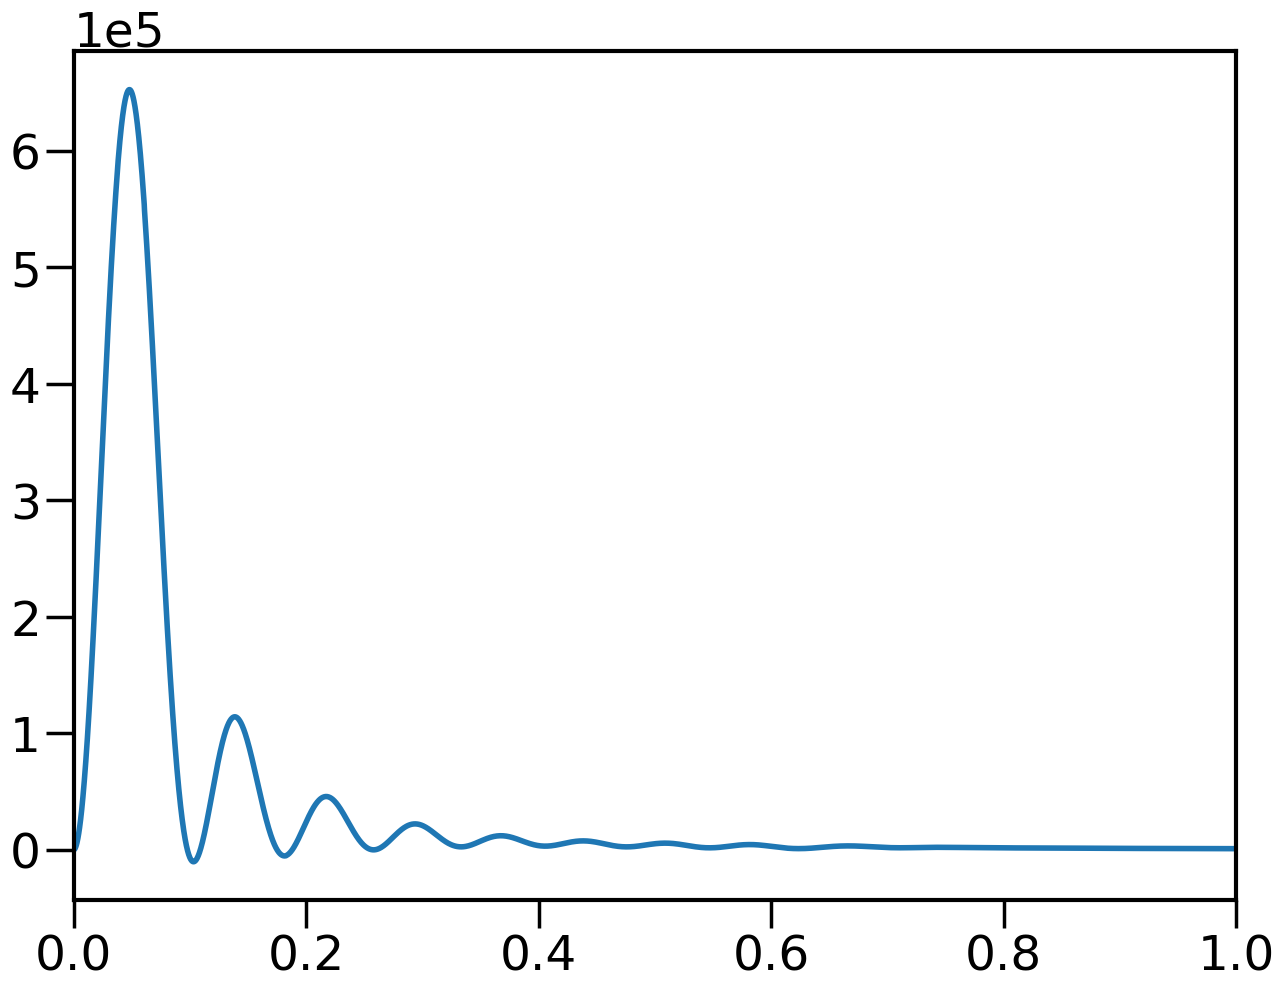

In [17]:
plot(theta_d[0,:],wtheta_d[0,:])
# plot(WT.theta_deg[(2,2)],wth)
# xscale('log')
xlim(0,1)

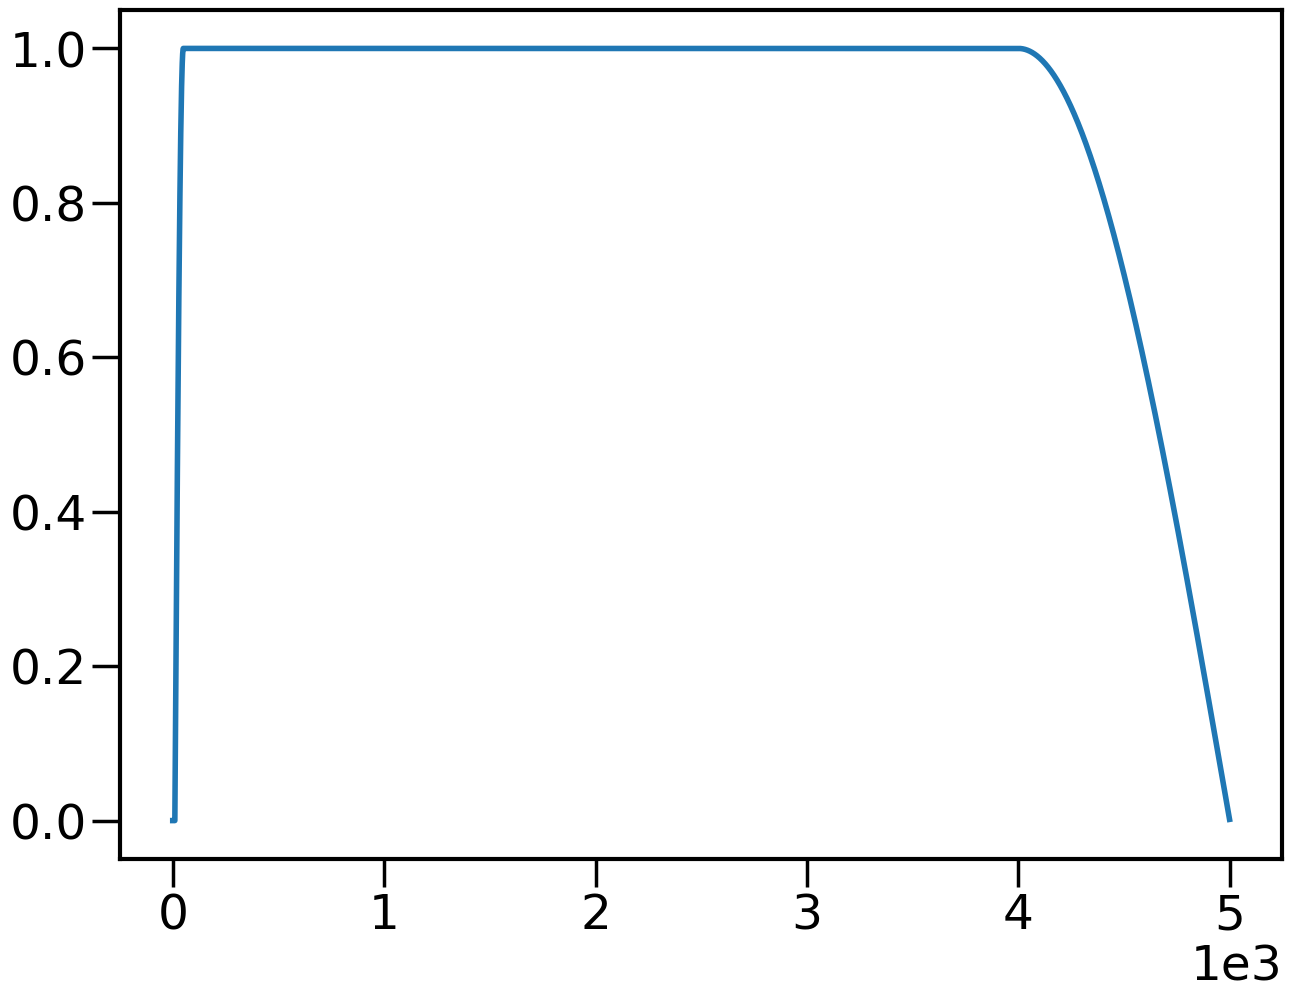

In [18]:
plot(l0,tf['taper_f'])

In [19]:
Skylens_kwargs=parse_dict(locals())
Skylens_kwargs_ub=copy.deepcopy(Skylens_kwargs)
Skylens_kwargs_ub['bin_xi']=False
Skylens_kwargs_ub['bin_cl']=False
Skylens_kwargs_ub['theta_bins']=th

In [20]:
kappa_xi0_ub=Skylens(**Skylens_kwargs_ub)
kappa_xi0=Skylens(**Skylens_kwargs)


/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/cov_utils.py:91: RuntimeWarning: invalid value encountered in true_divide
/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide


pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.015
power spectra camb_pk_too_many_z
Win gen: step size 6 5000 513.0 10
Window done. Size: 0.0
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.015
power spectra camb_pk_too_many_z
Win gen: step size 6 5000 513.0 10
Window done. Size: 0.0


In [21]:
cl_bu=client.gather(kappa_xi0.cl_bin_utils)
xi_bu=client.gather(kappa_xi0.xi_bin_utils)

In [22]:
%time xiHG_ub=kappa_xi0_ub.xi_tomo()
# %time xiH_ub=xiHG_ub['stack'].compute() #FIXME: bug in unbinned stacking
%time xi0ub=client.compute(xiHG_ub['xi']).result()
%time clG_ub=kappa_xi0_ub.cl_tomo()
# %time xiH_ub=xiHG_ub['stack'].compute() #FIXME: bug in unbinned stacking
%time cl0ub=client.compute(clG_ub['cl']).result()

/verafs/scratch/phy200040p/sukhdeep/miniconda3/lib/python3.8/site-packages/skylens-0.1-py3.8.egg/skylens/angular_power_spectra.py:115: RuntimeWarning: divide by zero encountered in true_divide


scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
Done xi graph 0.001277 1309.408
CPU times: user 32.7 s, sys: 6.29 s, total: 39 s
Wall time: 52.3 s
CPU times: user 134 ms, sys: 344 ms, total: 478 ms
Wall time: 798 ms
scatter_dict got empty dictionary
cl graph done
gather_dict got empty dictionary
CPU times: user 1.06 s, sys: 1.89 s, total: 2.95 s
Wall time: 8.3 s
CPU times: user 26.2 ms, sys: 7.38 ms, total: 33.6 ms
Wall time: 48.1 ms


In [23]:
l_bins_center=kappa_xi0.binning.bin_1d(xi=cl0ub[corr][bi]*kappa_xi0_ub.l,bin_utils=cl_bu)
l_bins_center/=kappa_xi0.binning.bin_1d(xi=cl0ub[corr][bi],bin_utils=cl_bu)

theta_bins_center=kappa_xi0.binning.bin_1d(xi=xi0ub[corr][s][bi]*WT.theta_deg[s],bin_utils=xi_bu[s])
theta_bins_center/=kappa_xi0.binning.bin_1d(xi=xi0ub[corr][s][bi],bin_utils=xi_bu[s])

In [24]:
Skylens_kwargs=parse_dict(locals())
Skylens_kwargs_b=copy.deepcopy(Skylens_kwargs)
Skylens_kwargs_b['use_binned_l']=True
Skylens_kwargs_b['use_binned_theta']=True
Skylens_kwargs_b['WT']=WT_b

In [25]:
kappa_xi0=Skylens(**Skylens_kwargs)
kappa_xi0b=Skylens(**Skylens_kwargs_b)

pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.015
power spectra camb_pk_too_many_z
Win gen: step size 6 5000 513.0 10
Window done. Size: 0.0
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.015
power spectra camb_pk_too_many_z
Win gen: step size 6 5000 513.0 10
Window done. Size: 0.0
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.015
power spectra camb_pk_too_many_z
Win gen: step size 5 50 513.0 10
Window done. Size: 0.0
pk_params dict was none, intialized with default
cosmo_params dict was none, intialized with default
cosmology interpolation range 0.0 5.015
power spectra camb_pk_too_many_z
Win gen: step size 6 5000 513.0 10
Window done. Size: 0.0
scatter_dict got empty dictionary
cl graph done
gather_dict got empty dict

distributed.nanny - WARNING - Restarting worker


CommClosedError: in <closed TCP>: Stream is closed

In [ ]:
cl_bu=client.gather(kappa_xi0.cl_bin_utils)
xi_bu=client.gather(kappa_xi0.xi_bin_utils)

In [ ]:
%time xiHG0=kappa_xi0.xi_tomo()
%time xiH0=xiHG0['stack'].compute()
%time xi0=client.compute(xiHG0['xi']).result()

In [ ]:
%time xiHG_b=kappa_xi0b.xi_tomo()
%time xiH_b=xiHG_b['stack'].compute()
%time xi0b=client.compute(xiHG_b['xi']).result()

In [ ]:
plot(thb,thb*xi0b[corr][s][bi])
plot(thb,thb*xi0[corr][s][bi],'--')
xscale('log')
show()
plot(thb,xi0b[corr][s][bi]/xi0[corr][s][bi],'--')
xscale('log')

In [ ]:
def bin_2d_WT_inv(wig_mat=[],wig_norm=None,bin_utils_xi=None,bin_utils_cl=None,
                wt_b=None,wt0=None,use_binned_l=False,win_xi=None):

        wig_mat=wig_mat*wig_norm
#         wig_mat=wig_mat.T
        if bin_utils_xi is not None:
            binning_mat_xi=bin_utils_xi['binning_mat']
            if wt_b is None:
                wt_b=bin_utils_xi['wt_b']
            if wt0 is None:
                wt0=bin_utils_xi['wt0']
            if len(wt0.shape)==1:
                binning_mat_xi2=wt0[:,None]*binning_mat_xi*wt_b
            else:
                binning_mat_xi2=wt0@binning_mat_xi@wt_b #FIXME: Test this.
            print(wig_mat.shape,binning_mat_xi2.shape)
            wm=wig_mat@binning_mat_xi2
            
        else:
            wm=wig_mat
        
        wig_mat_b=wm
        if bin_utils_cl is not None and use_binned_l:
            bin_mat_cl=bin_utils_cl['binning_mat']
            
            rdr=bin_utils_cl['r_dr']
            bin_mat_cl=bin_mat_cl*rdr[:,None]/bin_utils_cl['norm'][None,:]
            
            wig_mat_b=bin_mat_cl.T@wm
        return wig_mat_b

In [ ]:
%time clG0b=kappa_xi0b.cl_tomo()
%time cl0b=client.compute(clG0b['cl_b']).result()

%time clG0=kappa_xi0.cl_tomo()
%time cl0=client.compute(clG0['cl_b']).result()

%time cl0_0=client.compute(clG0['cl']).result()

In [ ]:
wd_b=kappa_xi0b.WT_binned[corr][s][bi].result()
wd_bi=numpy.linalg.pinv(wd_b)

In [ ]:
wd_bi2=kappa_xi0b.inv_WT_binned[corr][s][bi].result()

In [ ]:
#reconstructing power spectra. Large scales are biased due to missing large theta values.
plot(lb,cl0[corr][(0,0)])
plot(lb,wd_bi@xi0b[corr][s][bi])
plot(lb,(wd_bi2@xi0b[corr][s][bi]))
loglog()
show()
plot(lb,wd_bi@xi0b[corr][s][bi]/cl0[corr][bi])
plot(lb,wd_bi2@xi0b[corr][s][bi]/cl0[corr][bi])
hlines(1,1,2000,color='k')
xscale('log')
ylim(0.9,1.21)

In [ ]:
plot(lb,wd_bi2@xi0b[corr][s][bi]/cl0[corr][bi],'bo-')
hlines(1,1,2000,color='k')
hlines(1.01,1,2000,color='k',ls='--')
hlines(.99,1,2000,color='k',ls='--')
xscale('log')
ylim(0.9,1.121)
xlim(10,2000)

In [ ]:
fig, ax =subplots(2,1,figsize=(20,15),sharex='col',sharey='row')
pS=ax[0]
pR=ax[1]
l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th*d2r,xi=xi0ub[corr][s][bi],s1_s2=s,wig_d=WT.wig_d[s].T,wig_norm=WT.inv_wig_norm)
pS.plot(l_inv,cl0_0[corr][bi],alpha=1,zorder=10,c='k')
pS.plot(l_inv,cl_inv,c=colors[0],alpha=0.5)
pS.plot(lb,wd_bi2@xi0b[corr][s][bi],c=colors[0],marker=markers[0],label=str(theta_min*60),lw=0)


pR.plot(l_inv,1-cl_inv/cl0_0[corr][bi],c=colors[0],alpha=0.5)
pR.plot(lb,1-wd_bi2@xi0b[corr][s][bi]/cl0[corr][bi],c=colors[0],marker=markers[0],label=str(theta_min*60),lw=0)

thcs=[0.1,1,10]
i=1
for thc in thcs:
    x=thb*60>thc
    xi_x=xi0b[corr][s][bi]*1.
    xi_x[~x]=0
    pS.plot(lb,(wd_bi2@xi_x),c=colors[i],marker=markers[i],label=str(thc),ls=None,lw=0)
    pR.plot(lb,1-(wd_bi2@xi_x)/cl0[corr][bi],c=colors[i],marker=markers[i],label=str(thc),ls=None,lw=0)
    x=th*60>thc
    l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th[x]*d2r,wig_theta=th[x]*d2r,xi=xi0ub[corr][s][bi][x],
                                              s1_s2=s,wig_d=WT.wig_d[s][x,:].T,wig_norm=WT.inv_wig_norm[x])
    pR.plot(l_inv,1-cl_inv/cl0_0[corr][bi],c=colors[i],alpha=0.5)#,label=r'$\theta_{min}=$'+str(thc))
    pS.plot(l_inv,cl_inv,c=colors[i],alpha=0.5)#,label=r'$\theta_{min}=$'+str(thc))

    i+=1
pR.hlines(0,1,2000,color='k')
pR.hlines(.01,1,2000,color='k',ls='--')
pR.hlines(-0.01,1,2000,color='k',ls='--')
pR.set_xscale('log')
pS.set_yscale('log')
pR.set_yscale('symlog',linthreshy=0.01)
# ylim(0.9,1.121)
pR.set_ylim(-0.1,3)
pS.set_ylim(5.e-9,5.e-6)
pR.set_xlim(10,2000)
pR.set_xlabel('$\ell$')
pR.set_ylabel(r'$1-\frac{C_\ell(recons)}{C_\ell (theory)}$')
pS.set_ylabel(r'$C_\ell$')
pS.text(x=21,y=5e-8,s=corr_labels[corr][s])
pS.legend(loc='upper right',ncol=2)
fname='WT_inv_th_min_comp_'+corr_fnames[corr][s]
fname=fig_home+fname
fname+='.pdf'
fig.savefig(fname,bbox_inches='tight',format='pdf')
print('saved to ',fname)    
show()

In [ ]:
thcs=[0.1,1,10]
i=0
for thc in thcs:
    x=th*60>thc
    l_inv,cl_inv=WT.inv_projected_correlation(theta_xi=th[x]*d2r,wig_theta=th[x]*d2r,xi=xi0ub[corr][s][bi][x],s1_s2=s,wig_d=WT.wig_d[s][x,:].T,wig_norm=WT.inv_wig_norm[x])
    plot(l_inv,cl_inv/cl0_0[corr][bi],c=colors[i],label=r'$\theta_{min}=$'+str(thc))
    i+=1
hlines(1,1,2000,color='k')
hlines(1.01,1,2000,color='k',ls='--')
hlines(.99,1,2000,color='k',ls='--')
xscale('log')
ylim(0.9,1.121)
xlim(10,5000)
legend()

In [ ]:
plot(thb,(wd_b@(wd_bi2@xi0b[corr][s][bi]))/xi0b[corr][s][bi])
# hlines(1,1,2000,color='k')
hlines(1.01,1,2000,color='k',ls='--')
hlines(.99,1,2000,color='k',ls='--')
xscale('log')
ylim(0.95,1.05)

In [ ]:
#bin centers need to be chosen carefully!!
plot(thb,wd_b@cl0[corr][bi]/xi0[corr][s][bi]) #difference is due to effective xi bin centers.
hlines(1,.1,10,color='k')
xscale('log')
# ylim(0.98,1.021)
show()
plot(lb,wd_bi@xi0[corr][s][bi]/cl0[corr][bi]) #difference is due to effective xi bin centers.
hlines(1,1,2000,color='k')
xscale('log')
ylim(0.98,1.021)

In [ ]:
plot(thb,thb*(wd_b@cl0[corr][bi]))
plot(thb,thb*xi0[corr][s][bi])
# hlines(1,.1,10,color='k')
xscale('log')
# ylim(0.98,1.021)

In [ ]:
crash

In [ ]:
bin_xi=True
bin_cl=True
theta_min2=.05/60
# theta_min=hp.nside2resol(512, arcmin = True)/60 #100/nside #1./60
theta_max2=600./60
n_theta_bins=105
# theta_bins,th=get_theta_bins(theta_min=theta_min,theta_max=theta_max,N_bins=n_theta_bins,binning_scheme='log',n_theta_samples=40)#,max_modes=1)
theta_bins2=np.logspace(np.log10(theta_min2),np.log10(theta_max2),n_theta_bins+1)
th2=np.logspace(np.log10(theta_min2),np.log10(theta_max2),n_theta_bins*40)
thb2=0.5*(theta_bins2[1:]+theta_bins2[:-1])
n_theta_bins=len(thb2)

l0_2=np.arange(1e4)

#Hankel Transform setup
WT_kwargs2={'l':l0_2,'theta':th2*d2r,'s1_s2':[(2,2),(2,-2),(0,0),(0,2)],
           'wig_d_taper_order_low':6,'wig_d_taper_order_high':10}
# if globals().get('WT') is None:
WT2=wigner_transform(**WT_kwargs2 )
WT2.gather_data()

In [ ]:
kappa_xi0_2=Skylens(shear_zbins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0_2, galaxy_zbins=None,
                       use_window=use_window,Tri_cov=Tri_cov,
                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=0.35,
                       store_win=store_win,window_lmax=window_lmax,
                      do_xi=do_xi,bin_xi=False,theta_bins=th2,WT=WT2,
                      use_binned_l=False,use_binned_theta=False,
                      nz_PS=10,do_pseudo_cl=False)

In [ ]:
xiHG_b2=kappa_xi0_2.xi_tomo()
# %time xiH_b2=xiHG_b2['stack'].compute()
%time xi0b2=client.compute(xiHG_b2['xi']).result()

In [ ]:
clG_b2=kappa_xi0_2.cl_tomo()
# %time xiH_b2=xiHG_b2['stack'].compute()
%time cl0b2=client.compute(clG_b2['cl']).result()

In [ ]:
l0_2=np.int64(l0_2)

In [ ]:
l_cut_weights=np.zeros_like(l0_2)
l_cut_weights[l0]=1
thc,thc_m=WT2.l_cut_coupling(l_cl=l0_2,l_cut_weights=l_cut_weights,taper=False)

In [ ]:
def l_cut_coupling2(WT,l_cl=None,theta_out=None,l_cut_weights=None,s1_s2=None,taper=False,**kwargs):
        self=WT
        if l_cut_weights is None:
            l_cl=self.l
            l_cut_weights=self.l_cut_weights
        if s1_s2 is None:
            s1_s2=self.s1_s2s
        theta_coupling={}
        theta_coupling_mat={}
        for (m1,m2) in s1_s2:
            th,theta_coupling[(m1,m2)]=self.projected_correlation(l_cl=l_cl,cl=l_cut_weights,taper=taper,s1_s2=(0,0),**kwargs)
            theta=self.theta[(m1,m2)]
            theta_diff=np.abs(theta_out[:,None]-theta_out)
            wtheta_intp=interp1d(theta,theta_coupling[(m1,m2)],bounds_error=False,kind='nearest',fill_value="extrapolate")
            theta_coupling_mat[(m1,m2)]=wtheta_intp(theta_diff)
            dth=np.gradient(theta_out)
            theta_coupling_mat[(m1,m2)]/=theta_coupling_mat[(m1,m2)]@dth
            theta_coupling_mat[(m1,m2)]*=dth
            print(np.all(np.isfinite(theta_coupling_mat[(m1,m2)])))
            print('l_cut_coupling:',theta_diff.shape,theta.shape,theta_coupling_mat[(m1,m2)].shape)
        return theta_coupling,theta_coupling_mat

In [ ]:
thc2,thc_m2=l_cut_coupling2(WT2,theta_out=th2*d2r,l_cl=l0_2,l_cut_weights=l_cut_weights,taper=False)

In [ ]:
s=(2,2)

In [ ]:
plot(th2,thc2[s])
xscale('log')

In [ ]:
tt,xi_c0=WT2.projected_correlation(l_cl=l0_2,cl=cl0b2[corr_ll][bi],s1_s2=s)
tt,xi_cb0=WT2.projected_correlation(l_cl=l0_2,cl=cl0b2[corr_ll][bi]*l_cut_weights,s1_s2=s)

In [ ]:
dd=th2[1:]-th2[:-1]
dd=np.append(dd,[0])

In [ ]:
(cl0b2[corr_ll][bi]*(2*l0_2+1)).sum()

In [ ]:
((np.gradient(th2)*xi_c0)@WT2.wig_d[s]).sum()

In [ ]:
th2

In [ ]:
plot(l0_2,cl0b2[corr_ll][bi])
# plot(l0_2,wdi@xi_c0,'--')
plot(l0_2,((th2*d2r*np.gradient(th2*d2r)*xi_c0)@WT2.wig_d[s])*2*np.pi,'--')
loglog()
show()
plot(l0_2,((th2*d2r*np.gradient(th2*d2r)*xi_c0)@WT2.wig_d[s])*2*np.pi/cl0b2[corr_ll][bi],'--')
# loglog()
ylim(0.9,1.2)

In [ ]:
# plot(th2,xi0b2[corr_ll][s][bi]/xi_c0)
plot(th2,xi0b2[corr_ll][s][bi])
plot(th2,xi_cb0)
plot(thb,xi0[corr_ll][s][bi])

xscale('log')

In [ ]:
xi_c=thc_m2[s]@xi0b2[corr_ll][s][bi]
bb=binning()
xi_bu=bb.bin_utils(r=th2,r_bins=theta_bins)
xi_cb=bb.bin_1d(xi=xi_c,bin_utils=xi_bu)

In [ ]:
dth=np.gradient(th2)

In [ ]:
cl_i=((th2*d2r*np.gradient(th2*d2r)*xi_c0)@WT2.wig_d[s])*2*np.pi
cl_i2=cl_i*l_cut_weights
tt,xi_i2=WT2.projected_correlation(l_cl=l0_2,cl=cl_i2,s1_s2=s)
tt,xi_i=WT2.projected_correlation(l_cl=l0_2,cl=cl_i,s1_s2=s)
xi_ib=bb.bin_1d(xi=xi_i,bin_utils=xi_bu)
xi_i2b=bb.bin_1d(xi=xi_i2,bin_utils=xi_bu)

In [ ]:
plot(thb,xi0[corr_ll][s][bi])
plot(th2,xi0b2[corr_ll][s][bi])
# plot(th2,xi_c)
plot(th2,xi_i)
plot(th2,xi_i2)
# plot(thb,xi_cb)
xscale('log')
yscale('log')
# ylim(0.98,1.021)

In [ ]:
plot(thb,xi0[corr_ll][s][bi]/xi_cb)
plot(thb,xi0[corr_ll][s][bi]/xi_ib)
plot(thb,xi0[corr_ll][s][bi]/xi_i2b)
# plot(thb2,thb2*(thc_m2[s]@xi0b2[corr_ll][s][bi]))
# plot(th2,th2*((dth*xi0b2[corr_ll][s][bi])@thc_m2[s])/(thc_m2[s]@dth))
hlines(1,.1,10,color='k')
xscale('log')
ylim(0.8,1.21)

In [ ]:
def theta_max_modes(theta):
    return theta**2

def get_theta_bins(theta_min=2.5/60,theta_max=2500./60,N_bins=10,binning_scheme='log',n_theta_samples=40
                   ,binning_mode='increasing',max_modes=None,min_modes=None):
    n_modes_min=theta_max_modes(theta_min)
    n_modes_max=theta_max_modes(theta_max)
    n_modes=n_modes_max-n_modes_min
    if binning_scheme=='log':
        n_modes_bin=np.logspace(np.log10(n_modes_min),np.log10(n_modes_max),N_bins+1)
    if binning_scheme=='linear':
        n_modes_bin=np.linspace(n_modes_min,n_modes_max,N_bins+1)
    if binning_scheme=='constant':
        n_modes_bin=np.ones(N_bins+1)*np.int(n_modes/N_bins)
    if binning_scheme=='log-linear':
        n_modes_bin=np.logspace(np.log10(n_modes_min),np.log10(max_modes),int(N_bins/2))
        n_modes_bin2=np.linspace(max_modes,n_modes_max,N_bins+1-int(N_bins/2))
        n_modes_bin=np.unique(np.sort(np.append(n_modes_bin,n_modes_bin2)))
        N_bins=len(n_modes_bin)-1
        print(n_modes_bin)
    if binning_mode=='decreasing':
        n_modes_bin=n_modes_bin[::-1]
        
    def bin_norm(n_modes_bin,n_modes):
        n_modes_bin=n_modes_bin/n_modes_bin.sum()
        n_modes_bin*=n_modes
#         n_modes_bin=np.int32(n_modes_bin)
#         n_modes_bin[n_modes_bin==0]+=1
        return n_modes_bin
    
    n_modes_bin=bin_norm(n_modes_bin,n_modes)
    if max_modes is not None:
        n_modes_bin[n_modes_bin>max_modes]=max_modes
    if min_modes is not None:
        n_modes_bin[n_modes_bin<min_modes]=min_modes
    
    theta_bins=np.zeros(N_bins+1)
    theta_bins[0]=theta_min
    theta_bins[-1]=theta_max
    dth=(theta_max-theta_min)/N_bins/100
    if dth==0:
        dth=1.e-5
    for i in np.arange(N_bins):
        n_mode_i=0
        theta_i=theta_bins[i]+dth/max(1,theta_bins[i]**2)
        while n_mode_i<n_modes_bin[i]:
            n_mode_i+=theta_i*dth
            theta_i+=dth
            if theta_i>=theta_max:
                break
        theta_bins[i+1]=theta_i
        if theta_i>=theta_max:
            theta_bins[i+1:]=theta_i
            theta_bins=np.unique(theta_bins)
            N_bins=len(theta_bins)-1
            break
    if theta_bins[-1]<theta_max:
        theta_bins[-1]=theta_max
    
    n_theta_sample=[]
    for i in np.arange(N_bins):
        th=np.linspace(theta_bins[i]*1.0001,.9999*theta_bins[i+1],n_theta_samples)
        n_theta_sample=np.append(n_theta_sample,th)
    n_theta_sample=np.sort(n_theta_sample)
    return theta_bins,n_theta_sample